# Benchmark Log Bloat Analysis

This notebook analyzes the space usage in benchmark results (specifically `results.json`) to identify why they are reaching several GBs and where the most significant bloat occurs.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

RUN_DIR = "benchmark_runs/2026-01-26_21-28-34"
RESULTS_FILE = Path(RUN_DIR) / "results.json"

def estimate_size(obj):
    if obj is None: return 0
    if isinstance(obj, str): return len(obj)
    return len(json.dumps(obj))

## Size Breakdown by Event Type
We iterate through all trace logs and measure the size of each event type.

In [2]:
data = []
with open(RESULTS_FILE, 'r') as f:
    results = json.load(f)

def process_logs(logs, source_type):
    for log in logs or []:
        data.append({
            'source': source_type,
            'event_type': log.get('type', 'unknown'),
            'content_size': estimate_size(log.get('content')),
            'tool_output_size': estimate_size(log.get('tool_output')),
            'details_size': estimate_size(log.get('details')),
            'total_size': estimate_size(log)
        })

for res in results:
    # Top-level logs
    process_logs(res.get('trace_logs'), 'top_level')
    
    # Attempt-level logs
    for attempt in res.get('generation_attempts') or []:
        process_logs(attempt.get('trace_logs'), 'attempt')

df = pd.DataFrame(data)
stats = df.groupby(['source', 'event_type'])['total_size'].agg(['sum', 'count', 'mean']).sort_values('sum', ascending=False)
stats['sum_mb'] = stats['sum'] / (1024*1024)
stats['percent'] = (stats['sum'] / stats['sum'].sum()) * 100
stats

sum  count          mean      sum_mb  \
source    event_type                                                        
attempt   tool_result          544867984   2669  2.041469e+05  519.626602   
top_level tool_result          532138762   2627  2.025652e+05  507.487070   
attempt   CLI_STDOUT_FULL      304483513    993  3.066299e+05  290.378106   
top_level CLI_STDOUT_FULL      297407745    978  3.040979e+05  283.630128   
attempt   CLI_STDERR            23515405  86813  2.708742e+02   22.426038   
top_level CLI_STDERR            23064633  85145  2.708865e+02   21.996148   
attempt   GEMINI_CLIENT_ERROR   10734987      8  1.341873e+06   10.237681   
          message                8877159   6808  1.303931e+03    8.465919   
top_level message                8754626   6721  1.302578e+03    8.349062   
attempt   tool_use               1412218   2669  5.291188e+02    1.346796   
top_level tool_use               1389898   2627  5.290818e+02    1.325510   
attempt   system_result           572129    993  5.761621e+02    0.545625   
top_level system_result           562948    978  5.756115e+02    0.536869   
attempt   init                    338613    993  3.410000e+02    0.322927   
top_level init                    333498    978  3.410000e+02    0.318048   
attempt   CLI_STDOUT_RAW            1070      4  2.675000e+02    0.001020   
top_level CLI_STDOUT_RAW             550      2  2.750000e+02    0.000525   

                                 percent  
source    event_type                      
attempt   tool_result          30.985596  
top_level tool_result          30.261709  
attempt   CLI_STDOUT_FULL      17.315393  
top_level CLI_STDOUT_FULL      16.913007  
attempt   CLI_STDERR            1.337276  
top_level CLI_STDERR            1.311641  
attempt   GEMINI_CLIENT_ERROR   0.610478  
          message               0.504827  
top_level message               0.497859  
attempt   tool_use              0.080310  
top_level tool_use              0.079041  
attempt   system_result         0.032536  
top_level system_result         0.032014  
attempt   init                  0.019256  
top_level init                  0.018965  
attempt   CLI_STDOUT_RAW        0.000061  
top_level CLI_STDOUT_RAW        0.000031

### Visualization of Usage
The following plot shows the total MB consumed by each log event type.

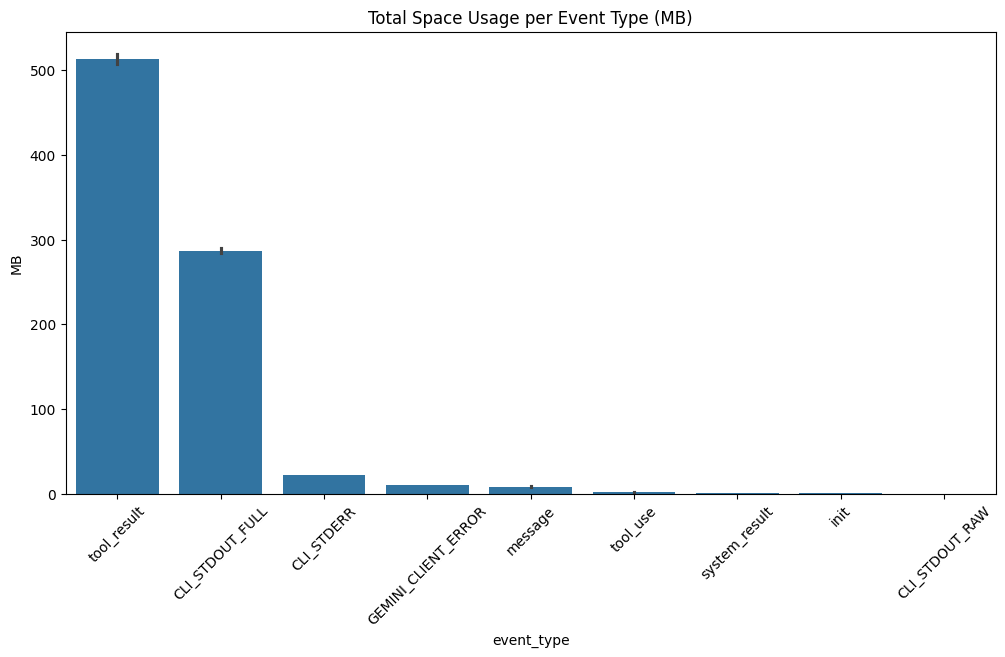

In [3]:
plt.figure(figsize=(12, 6))
sns.barplot(data=stats.reset_index(), x='event_type', y='sum_mb')
plt.title("Total Space Usage per Event Type (MB)")
plt.ylabel("MB")
plt.xticks(rotation=45)
plt.show()

## Findings and Optimization

1. **Duplication**: `tool_result` events store the same huge output in both `tool_output` and `details`. 
2. **Raw CLI Bloat**: `CLI_STDOUT_FULL` captures the raw JSON line from the CLI, which contains the entire tool output again.
3. **Multi-Attempt Multiplier**: Since `trace_logs` are stored both in `generation_attempts` and the top-level result, the bloat is multiplied by the number of retries.

**Optimization Implemented:**
- Truncate `tool_output` and `CLI_STDOUT_FULL` to 5KB.
- Remove `details` from `tool_result` (redundant).
- Apply `optimize_trace_logs` before saving results.